In [2]:
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
from popsims import sample_from_powerlaw
import astropy.units as u
from tqdm import tqdm
import popsims
import pandas as pd
from easyshapey import Box
from scipy.interpolate import interp1d, griddata
from findthegap.gapper import Gapper
import torch
import itertools
import numba 

path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'
path_bckgds= '../data/backgrounds/'
path_plot='../figures/'
isochrone_path=path_isochrone


mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']

In [1]:
def read_stream_file(N_pal5, gap_center, box, rgc, mhalo, vhalo,    distance_to_hit =0.5):
    
    #filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}'.format(rgc, mhalo, vhalo)
 
    #filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
    filename='no_self_grav_pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
    st=(np.load(path_streamdata+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0])['stream']
    
    x0=st.y.value
    y0=st.x.value

    center=np.nanmedian(np.array(rgc.split('_')).astype(float))

    #deptermine optimal rotation angle by fitting a line to the half stream
    mask= (x0-np.nanmedian(x0))>0.
    line = np.polyfit(x0[mask], y0[mask], 1)
    angle=np.arctan(line[0])
    x0, y0=rotate(x0, y0, -angle, c=(np.nanmedian(x0), np.nanmedian(y0)))

    xshift= np.nanmedian(x0)-center
    yshift=np.nanmedian(y0)-center

    x=x0-xshift
    y=y0-yshift

    xshift=gap_center[0]
    yshift=gap_center[1]

    x=x-xshift
    y=y-yshift
    
    choose=np.random.choice(np.arange(len(x)), N_pal5)
    
    return box.select(np.array([x[choose], y[choose]]))


def count_pal5_stars(mag_limit, dmod):
    dmod_pal5=16.85
    def read_pandas_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/cfht_pre2014_isochrones_pal5.txt').to_pandas()

    def read_roman_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/roman_isochrones_vega_pal5_3.7.txt').to_pandas()
    
    nsample=1e6
    masses= sample_from_powerlaw(-.5, xmin=0.1, xmax=10, nsample=nsample)
    cfht=read_pandas_isochrones()
    roman= read_roman_isochrones()
    comb= pd.concat([cfht, roman]).reset_index()
    
    
    isos={}
    for k in mag_keys:
        x= np.log10(comb.Mini.values)
        y=comb[k].values
        nans=np.logical_or(np.isnan(x), np.isnan(y))
        isos['mass']= masses
        #f=griddata(x[~nans], y[~nans], np.log10(masses) , fill_value=np.nan, method='linear', rescale=True)
        sort=np.argsort(x[~nans])
        f=interp1d(x[~nans][sort], y[~nans][sort], fill_value =np.nan, bounds_error=False)(np.log10(masses))
        isos.update({k: f+dmod_pal5})
    
    df=pd.DataFrame(isos)
    
    num_20_23= len(df.gmag.values[np.logical_and(df.gmag.values>=20, df.gmag.values<=23)])
    norm= (3000/num_20_23)
    
    #compute the difference between distance moduli and offset stars
    dist_mod_And = dmod- dmod_pal5
    
    return len(df.F087mag.values[df.F087mag.values<(mag_limit-dist_mod_And)])*norm


def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

def get_density(data, gridding_size, grid_data, bw, bounds, nboot=2):
    
    mineigval_PiHPi_boots =[]
    maxeigval_PiHPi_boots =[]
    #PiHPi_boots=[]
    dens_boots=[]
    
    for _ in range(nboot):
        boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                     replace=True) ## Sample with replacement:bootstrap
        gapp=Gapper(data[boot_indx], bw, bounds=bounds)
        
        dens=gapp.get_density(torch.tensor(grid_data),  requires_grad=False).flatten()
    
        #PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = gapp.get_PiHPi(pt) 
            _pihpi_eigval, _= np.linalg.eigh(_pihpi)
            #PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
           

        #PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        eigval_PiHPi=np.array(eigval_PiHPi)

        #option for using minium or maximum eigenvalue
        #if max_eigenvalue:
        max_eigval_PiHPi_k = np.nanmax(eigval_PiHPi, axis=1)
        #rescale everything between 0 and 1
        max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))

        #if not max_eigenvalue:
        min_eigval_PiHPi_k = np.nanmin(eigval_PiHPi, axis=1)
        min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))/(np.nanmax(min_eigval_PiHPi_k)-np.nanmin(min_eigval_PiHPi_k))

        
        maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
        mineigval_PiHPi_boots.append(min_eigval_PiHPi_k)
        #PiHPi_boots.append(PiHPis_grid)
        dens_boots.append(dens)
        
    maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
    mineigval_PiHPi_boots = np.array(mineigval_PiHPi_boots)
    
    #median
    med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
    med_mineigval_pihpi = np.median(mineigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
    med_dens=np.nanmedian([np.array(x) for x in dens_boots], axis=0).reshape((gridding_size[0], gridding_size[1]))
    
    return {'density':med_dens,
            'grid_data':grid_data,
            'max_eigen':med_maxeigval_pihpi,
            'min_eigen':med_mineigval_pihpi}

def make_an_image(d, rgc, mag_limit,  gap_center, box_size, box_center, distance_to_hit=0.5, vhalo=-50):
    mhalo=5e6
    fname=path_isochrone+'simulated_df_at_M31_normalized_extended_rgc{}.h5'.format(rgc)

    MASTER_DF=pd.read_hdf(fname, key='data')
  
    d_galaxy=d*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)

    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
    b=make_box( (center, center), roman_fov.value, roman_fov.value)

    dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
    N_pal5=int(count_pal5_stars(mag_limit, dmod_galaxy))
    vls=read_stream_file(N_pal5,gap_center, b, rgc, mhalo, vhalo,  distance_to_hit=distance_to_hit)

    bck=read_cmd_file(MASTER_DF, rgc, d_galaxy, mag_limit)
    s=b.select(bck[['x_coord', 'y_coord']])
    img= [np.concatenate([vls[0], s.x.values]), np.concatenate([vls[1], s.y.values])]
    
    return img

def make_grid(center, xsize, ysize):
    bounds = [[center-xsize/2, center+xsize/2], [center-ysize/2, center+ysize/2]]
    #then add data around it
    print (bounds)
    gridding_size = np.array([70, 20]).astype(int)
    grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    print (len(grid_data[:,0]), len(meshgrid[0]))
    return meshgrid, grid_data, bounds, gridding_size

def draw_data_round_grid(data, bw, bounds):
    #draw data within 2*bw
    n=2
    boolean=np.logical_and.reduce([data[0] > bounds[0][0]-n*bw,
                                   data[0] < bounds[0][1]+n*bw,
                                   data[1] >  bounds[1][0]-n*bw,
                                   data[1] <  bounds[1][1]+n*bw])
    
    return [data[0][boolean], data[1][boolean]]   

In [ ]:
backgrounds_dmod24.43rgc30_40mlimit27.15.npy


In [36]:
center=15
d_galaxy=770*u.kpc
rgc='10_20'
mhalo=5e6
vhalo=-50
mag_limit=27.15

b=make_box( (center, center), 30, 30)
dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
N_pal5=int(count_pal5_stars(mag_limit, dmod_galaxy))
vls=read_stream_file(N_pal5, (2.55, 0.55), b, rgc, mhalo, vhalo,  distance_to_hit=0.5)
pol_st= np.poly1d(np.polyfit(vls[0], vls[1], 2))

In [182]:
def projected_coords_along_stream(xgrid, point, pol):

    yprime=np.poly1d(np.polyder(pol))(xgrid) 
    y= pol(xgrid)
    #calculate slope of line from point to any point along the polynomials
    slopes=(y-point[1])/(xgrid-point[0])
    #difference between slope and derivative
    diffs= np.abs(yprime-slopes)
    #tangent poin
    best_idx= np.argmin(diffs)
    tangent_point= xgrid[best_idx], y[best_idx]
    
    #x-perpendiciular is 
    return yprime, slopes, tangent_point

def projected_min_along_stream(xgrid, point, pol):

    yprime=np.poly1d(np.polyder(pol))(xgrid) 
    y= pol(xgrid)
    diffs= np.abs(y-point[1])
    #tangent poin
    best_idx= np.argmin(diffs)
    tangent_point= xgrid[best_idx], y[best_idx]
    
    #x-perpendiciular is 
    return yprime, slopes, tangent_point

In [138]:
xgrid=np.linspace(5, 25, 1000)

In [127]:
bcks=np.random.uniform( 5, 25, (10000, 2)).T

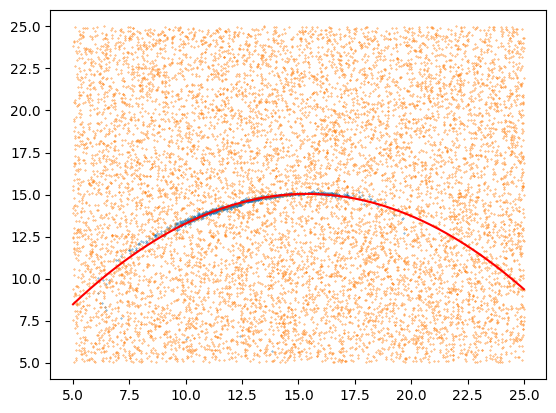

In [128]:
fig, ax=plt.subplots()
ax.scatter(vls[0], vls[1], s=0.1)
#ax.scatter(ts[0], ts[1], s=0.1)
ax.scatter(bcks[0], bcks[1], s=0.1)
plt.plot(xgrid, pol_st(xgrid), c='r')

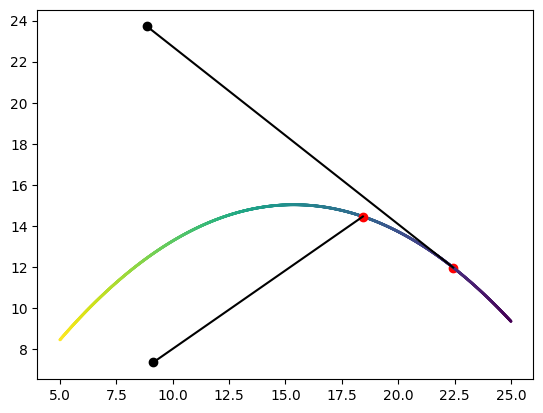

In [187]:
fig, ax=plt.subplots()
for _ in range(0, 2):
    point=bcks.T[np.random.choice(len(bcks[0]))]

    yp, slope, proj= projected_coords_along_stream(xgrid, point , pol_st)


    ax.scatter(xgrid, pol_st(xgrid), c=yp, s=1)
    ax.scatter(point[0], point[1], c='k')
    ax.scatter(proj[0], proj[1], c='r')
    ax.plot([point[0], proj[0]], [point[1], proj[1]], c='k')

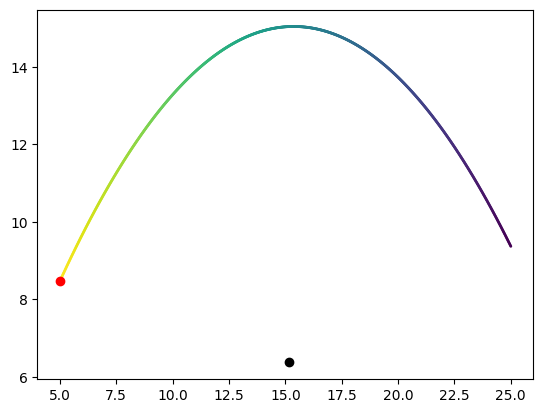